# Tree
Questo notebook serve per racchiudere quanto di utile per lo sviluppo di codice per valutare la scelta di alberi decisionali per il dataset scelto.

## Scaricamento dei dati

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
import requests
import zipfile
import io
import os
import glob
import pandas as pd

class DataDownloaderExtractor(BaseEstimator, TransformerMixin):
    """
    A custom transformer to download and extract data from given URLs.

    Args:
        urls (list): A list of URLs to zip files.
        output_dir (str): The directory to save the extracted files.
    """
    def __init__(self, urls, output_dir="dataset"):
        self.urls = urls
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as there's nothing to fit.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Downloads and extracts data from the provided URLs.

        Args:
            X: Input data (ignored).

        Returns:
            list: A list of paths to the extracted CSV files.
        """
        for url in self.urls:
            try:
                print(f"Downloading {url}...")
                response = requests.get(url, stream=True)
                response.raise_for_status() # Raise an exception for bad status codes

                # Read the zip file from the response content
                with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                    # Extract all contents to the specified output directory
                    zip_ref.extractall(self.output_dir)
                    print(f"Extracted files from {url} to {self.output_dir}")

            except requests.exceptions.RequestException as e:
                print(f"Error downloading {url}: {e}")
            except zipfile.BadZipFile:
                print(f"Error: The downloaded file from {url} is not a valid zip file.")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

        print("Download and extraction complete.")
        csv_files = glob.glob(os.path.join(self.output_dir, "*.csv"))
        print("CSV files found:", csv_files)
        return csv_files

# Example usage with a scikit-learn pipeline
from sklearn.pipeline import Pipeline

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip",
]

# Create the custom transformer
downloader_extractor = DataDownloaderExtractor(urls=urls, output_dir="downloaded_data")

# You can add other steps to the pipeline if needed, e.g., a data loader
# For this example, we just have the download and extract step

pipeline = Pipeline([
    ('download_and_extract', downloader_extractor),
    # Add more steps here if needed, e.g., loading the CSV files into pandas DataFrames
])

# Run the pipeline
# The fit method is called first (though it does nothing in this transformer)
# Then the transform method is called to perform the download and extraction
extracted_files = pipeline.fit_transform(None) # Pass None as input data, as it's not used

print("\nPipeline execution complete.")
print("Extracted files:", extracted_files)


Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']

Pipeline execution complete.
Extracted files: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']


## Estrazione dei dati

In [12]:
class CSVLoader(BaseEstimator, TransformerMixin):
    """
    A custom transformer to load specific CSV files into pandas DataFrames
    and return them in a format suitable for scikit-learn pipelines (e.g., as a tuple).

    Assumes that the input X is a list of file paths, typically produced
    by a previous step in the pipeline.

    Args:
        x_filename (str): The base name of the file containing features (e.g., 'X_train.csv').
        y_filename (str): The base name of the file containing the target (e.g., 'y_train.csv').
    """
    def __init__(self, x_filename='X_train.csv', y_filename='y_train.csv'):
        self.x_filename = x_filename
        self.y_filename = y_filename
        self.x_data = None
        self.y_data = None

    def fit(self, X, y=None):
        """
        Fits the transformer. This method will load the data.

        Args:
            X: A list of file paths (expected to contain x_filename and y_filename).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        x_file_path = None
        y_file_path = None

        # Find the correct file paths in the input list
        for file_path in X:
            if os.path.basename(file_path) == self.x_filename:
                x_file_path = file_path
            elif os.path.basename(file_path) == self.y_filename:
                y_file_path = file_path

        if x_file_path is None:
            raise FileNotFoundError(f"Could not find {self.x_filename} in the provided file list.")
        if y_file_path is None:
             raise FileNotFoundError(f"Could not find {self.y_filename} in the provided file list.")

        try:
            print(f"Loading {x_file_path} into x_data...")
            self.x_data = pd.read_csv(x_file_path)
            print(f"Loading {y_file_path} into y_data...")
            self.y_data = pd.read_csv(y_file_path) # Or read_fwf depending on the format
            print("Data loading complete.")

        except FileNotFoundError as e:
            print(f"Error loading file: {e}")
            # You might want to re-raise the exception or handle it differently
            raise
        except pd.errors.EmptyDataError:
            print(f"Error: One of the files ({self.x_filename} or {self.y_filename}) is empty.")
            raise
        except Exception as e:
            print(f"An unexpected error occurred while loading data: {e}")
            raise

        return self

    def transform(self, X):
        """
        Returns the loaded data (x_data, y_data).

        Args:
            X: Input data (ignored, data is loaded in fit).

        Returns:
            tuple: A tuple containing (x_data, y_data) as pandas DataFrames.
        """
        if self.x_data is None or self.y_data is None:
             raise RuntimeError("Data has not been loaded yet. Call fit() first.")

        # Return the data in a format that can be passed to the next pipeline step
        # For scikit-learn estimators, the fit method usually expects X and y separately.
        # Returning a tuple (X, y) allows the next step's fit method to receive them.
        return (self.x_data, self.y_data)

# Add the CSVLoader to the pipeline
pipeline_with_loading = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv'))
    # Add more steps here, e.g., preprocessing, model training
])

# Run the pipeline
# The output of the 'load_csv' step will be a tuple (x_data, y_data)
loaded_data = pipeline_with_loading.fit_transform(None)

# Access the loaded data
x_data, y_data = loaded_data

print("\nLoaded x_data shape:", x_data.shape)
print("Loaded y_data shape:", y_data.shape)
print("\nFirst 5 rows of x_data:")
print(x_data.head())
print("\nFirst 5 rows of y_data:")
print(y_data.head())

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.

Loaded x_data shape: (742625, 8)
Loaded y_data shape: (742625, 3)

First 5 rows of x_data:
   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  
0   99.6400  
1   91.3866  
2   90.9600  
3  100.2800  
4   92.1700  

First 5 rows o

## Creazione train-set e test-set

In [14]:
from sklearn.model_selection import train_test_split

class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom transformer to preprocess the data:
    - Drop the 'id' column from x_data.
    - Merge the 'faulty' column from y_data into x_data.
    - Split the merged data into training and testing sets.

    Assumes the input is a tuple (x_data, y_data) as pandas DataFrames,
    typically from a previous pipeline step like CSVLoader.
    """
    def __init__(self, test_size=0.2, random_state=None):
        self.test_size = test_size
        self.random_state = random_state
        self.data_train = None
        self.data_test = None

    def fit(self, X, y=None):
        """
        Fits the transformer by preprocessing and splitting the data.

        Args:
            X: A tuple (x_data, y_data) where x_data is the features DataFrame
               and y_data is the target DataFrame.
            y: Target data (ignored, as the target is expected in y_data).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (x_data, y_data).")

        x_data, y_data = X

        if not isinstance(x_data, pd.DataFrame) or not isinstance(y_data, pd.DataFrame):
             raise TypeError("Both elements in the input tuple must be pandas DataFrames.")

        # Drop the 'id' column from x_data if it exists
        if 'id' in x_data.columns:
            print("Dropping 'id' column from x_data...")
            x_data_processed = x_data.drop('id', axis=1)
        else:
            print("'id' column not found in x_data. Skipping drop.")
            x_data_processed = x_data.copy()

        # Check if 'faulty' column exists in y_data and merge it
        if 'faulty' in y_data.columns:
            print("Merging 'faulty' column from y_data into x_data...")
            # Ensure dataframes can be merged, e.g., they have a common index or column
            # Assuming they can be concatenated side-by-side based on index
            # If merging by a specific column is needed, adjust here
            merged_data = pd.concat([x_data_processed, y_data['faulty']], axis=1)
        else:
             raise ValueError("'faulty' column not found in y_data.")

        print(f"Splitting data into train ({1-self.test_size:.0%}) and test ({self.test_size:.0%})...")
        # Split the merged data into training and testing sets
        self.data_train, self.data_test = train_test_split(
            merged_data,
            test_size=self.test_size,
            random_state=self.random_state
        )
        print("Data splitting complete.")

        return self

    def transform(self, X):
        """
        Returns the split training and testing data.

        Args:
            X: Input data (ignored, splitting is done in fit).

        Returns:
            tuple: A tuple containing (data_train, data_test) as pandas DataFrames.
        """
        if self.data_train is None or self.data_test is None:
             raise RuntimeError("Data has not been preprocessed or split yet. Call fit() first.")

        # Return the split data
        return (self.data_train, self.data_test)

# Extend the existing pipeline to include the DataPreprocessor
pipeline_with_preprocessing = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)) # Add the preprocessor
    # Add more steps here, e.g., feature scaling, model training
])

# Run the pipeline
# The output of the 'preprocess_and_split' step will be a tuple (data_train, data_test)
split_data = pipeline_with_preprocessing.fit_transform(None)

# Access the split data
data_train, data_test = split_data

print("\nProcessed and Split Data:")
print("data_train shape:", data_train.shape)
print("data_test shape:", data_test.shape)


Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.

Processed and Split Data:
data_train shape: (594100, 8)
data_test shape: (148525, 8)


## Cambio nome delle feature

In [28]:
class FeatureRenamer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to rename columns of a pandas DataFrame.

    Assumes the input is a pandas DataFrame or a tuple containing DataFrames
    where the first element is the DataFrame to be renamed.
    If the input is a tuple, it renames columns of the first element and
    returns the tuple with the modified first element.

    Args:
        column_names (list): A list of the new column names in the desired order.
                             Expected to match the number of columns in the input DataFrame.
    """
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as renaming is done in transform.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Renames the columns of the input DataFrame.

        Args:
            X: The input data, expected to be a pandas DataFrame or a tuple
               where the first element is the DataFrame to be renamed.

        Returns:
            pandas.DataFrame or tuple: The DataFrame with renamed columns,
                                        or the original tuple with the modified DataFrame.
        """
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if not X:
                raise ValueError("Input tuple is empty.")
            df = X[0]
            rest_of_tuple = X[1:]
        else:
            df = X
            rest_of_tuple = ()

        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input (or the first element if a tuple) must be a pandas DataFrame.")

        if len(self.column_names) != df.shape[1]:
            # Consider if 'faulty' column is expected to be there or not
            # If 'faulty' is expected to be the last column, adjust the check or renaming
            if len(self.column_names) + 1 == df.shape[1] and 'faulty' in df.columns:
                 print("Input DataFrame has one more column than provided names (likely 'faulty').")
                 # Rename the first n columns and keep the last one ('faulty')
                 new_cols = self.column_names + ['faulty']
                 if len(new_cols) != df.shape[1]:
                      raise ValueError(f"Number of provided column names ({len(self.column_names)}) "
                                      f"plus 'faulty' does not match DataFrame columns ({df.shape[1]}).")
                 print(f"Renaming columns to: {new_cols}")
                 df_renamed = df.copy() # Create a copy to avoid modifying the original DataFrame in place
                 df_renamed.columns = new_cols
            else:
                 raise ValueError(f"Number of provided column names ({len(self.column_names)}) "
                                f"does not match the number of columns in the DataFrame ({df.shape[1]}).")
        else:
            print(f"Renaming columns to: {self.column_names}")
            df_renamed = df.copy() # Create a copy to avoid modifying the original DataFrame in place
            df_renamed.columns = self.column_names

        if is_tuple:
            return (df_renamed,) + rest_of_tuple
        else:
            return df_renamed

# Define the new column names
new_names_for_train_data = ['torque_meas', 'outside_air_temp', 'mean_gas_temp',
                            'power_avail', 'indicated_air_speed', 'net_power',
                            'compressor_speed', 'health_state']

# Extend the existing pipeline to include the FeatureRenamer
# Apply it to the output of the preprocessor, which is (data_train, data_test)
pipeline_with_renaming = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)),
    # Add the renamer step
    # It expects the input tuple (data_train, data_test)
    # It will rename the columns of the first element (data_train)
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data))
    # Note: This current setup will only rename data_train.
    # If you need to rename data_test as well, you might need
    # a custom transformer that handles the tuple and applies renaming to both.
    # Or handle renaming after the pipeline if both are needed.
    # For this example, we'll apply it assuming the renamer modifies the first element.
])

# Run the pipeline
# The output of the 'rename_features' step will be (data_train_renamed, data_test)
# (or potentially just data_train_renamed if the renamer returned only the first element,
# depending on its implementation. The current implementation returns the tuple.)
processed_and_renamed_data = pipeline_with_renaming.fit_transform(None)

# Access the data
# Assuming the renamer returns the tuple (renamed_data_train, data_test)
data_train_renamed, data_test_original = processed_and_renamed_data

print("\nProcessed, Split, and Renamed Data (Train Set):")
print("data_train_renamed shape:", data_train_renamed.shape)
print("data_test_original shape:", data_test_original.shape) # data_test is not renamed by this step

print("\nColumns of data_train_renamed:")
print(data_train_renamed.columns)

print("\nFirst 5 rows of data_train_renamed:")
print(data_train_renamed.head())

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.
Renaming columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']

Processed, Split, and Renamed Data (Train Set):
data_train_renamed shape: (594100, 8)
data_test_original shape: (148525, 8)

Columns of data_train_renamed:
Index(['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail',
       'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'],
      dt

## Standardizzazione

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import pandas as pd

class FeatureRenamer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to rename columns of a pandas DataFrame.

    Assumes the input is a pandas DataFrame or a tuple containing DataFrames
    where the first and second elements are the DataFrames to be renamed.
    If the input is a tuple, it renames columns of the first and second elements and
    returns the tuple with the modified elements.

    Args:
        column_names (list): A list of the new column names in the desired order.
                             Expected to match the number of columns in the input DataFrames
                             (excluding the target column if applicable).
    """
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as renaming is done in transform.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Renames the columns of the input DataFrame(s).

        Args:
            X: The input data, expected to be a pandas DataFrame or a tuple
               where the first and second elements are the DataFrames to be renamed.

        Returns:
            pandas.DataFrame or tuple: The DataFrame(s) with renamed columns,
                                        or the original tuple with the modified DataFrames.
        """
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if len(X) < 2:
                raise ValueError("Input tuple must contain at least two elements to be renamed.")
            df1 = X[0]
            df2 = X[1]
            rest_of_tuple = X[2:]
        else:
            df1 = X
            df2 = None # Only one DataFrame provided
            rest_of_tuple = ()

        if not isinstance(df1, pd.DataFrame):
            raise TypeError("Input (or the first element if a tuple) must be a pandas DataFrame.")
        if is_tuple and not isinstance(df2, pd.DataFrame):
             raise TypeError("The second element in the input tuple must be a pandas DataFrame.")


        # Function to rename columns of a single DataFrame
        def _rename_df_columns(df, column_names):
            # Check if the DataFrame contains the 'faulty' column as the last column
            if len(column_names) + 1 == df.shape[1] and df.columns[-1] == 'faulty':
                 print(f"Input DataFrame has one more column than provided names (likely 'faulty'). Renaming {df.shape[1]-1} columns.")
                 new_cols = column_names + ['faulty']
                 if len(new_cols) != df.shape[1]:
                      # This should ideally not happen if the previous check was correct,
                      # but adding for safety
                      raise ValueError(f"Internal renaming logic error. Number of columns after adding 'faulty' ({len(new_cols)}) "
                                      f"does not match DataFrame columns ({df.shape[1]}).")
                 print(f"Renaming columns to: {new_cols}")
                 df_renamed = df.copy() # Create a copy
                 df_renamed.columns = new_cols
            elif len(column_names) == df.shape[1]:
                print(f"Renaming all columns to: {column_names}")
                df_renamed = df.copy() # Create a copy
                df_renamed.columns = column_names
            else:
                 raise ValueError(f"Number of provided column names ({len(column_names)}) "
                                f"does not match the number of columns in the DataFrame ({df.shape[1]}). "
                                f"Expected {df.shape[1]} or {df.shape[1]-1} + 'faulty'.")
            return df_renamed

        # Rename the first DataFrame
        df1_renamed = _rename_df_columns(df1, self.column_names)

        # If input was a tuple, rename the second DataFrame as well
        if is_tuple:
            # We use the same column names for the second DataFrame,
            # assuming it has the same structure except for potentially being the test set.
            # The _rename_df_columns function handles the 'faulty' column check.
            df2_renamed = _rename_df_columns(df2, self.column_names)
            return (df1_renamed, df2_renamed) + rest_of_tuple
        else:
            return df1_renamed

# Define the new column names (same as before)
new_names_for_data = ['torque_meas', 'outside_air_temp', 'mean_gas_temp',
                      'power_avail', 'indicated_air_speed', 'net_power',
                      'compressor_speed'] # Note: Exclude 'health_state' here as it's the target


class DataScaler(BaseEstimator, TransformerMixin):
    """
    A custom transformer to apply StandardScaler to the features of the data.

    Assumes the input is a tuple (data_train, data_test) as pandas DataFrames,
    where the last column is the target variable. It scales all columns
    except the last one.
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.scaled_data_train = None
        self.scaled_data_test = None
        self.feature_columns = None
        self.target_column = None

    def fit(self, X, y=None):
        """
        Fits the StandardScaler on the training data features.

        Args:
            X: A tuple (data_train, data_test) where data_train and data_test
               are pandas DataFrames. The last column is assumed to be the target.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
             raise TypeError("Both elements in the input tuple must be pandas DataFrames.")

        # Assuming the last column is the target
        self.target_column = data_train.columns[-1]
        self.feature_columns = data_train.columns[:-1]

        print(f"Fitting StandardScaler on feature columns: {list(self.feature_columns)}...")
        # Fit the scaler on the training data's features
        self.scaler.fit(data_train[self.feature_columns])
        print("StandardScaler fitting complete.")

        # Transform both training and testing data features
        self.scaled_data_train = data_train.copy()
        self.scaled_data_test = data_test.copy()

        self.scaled_data_train[self.feature_columns] = self.scaler.transform(data_train[self.feature_columns])
        self.scaled_data_test[self.feature_columns] = self.scaler.transform(data_test[self.feature_columns])
        print("Data scaling complete.")


        return self

    def transform(self, X):
        """
        Returns the scaled training and testing data.

        Args:
            X: Input data (ignored, scaling is done in fit).

        Returns:
            tuple: A tuple containing (scaled_data_train, scaled_data_test) as pandas DataFrames.
        """
        if self.scaled_data_train is None or self.scaled_data_test is None:
             raise RuntimeError("Data has not been scaled yet. Call fit() first.")

        # Return the scaled data
        return (self.scaled_data_train, self.scaled_data_test)

# Extend the existing pipeline to include the DataScaler
pipeline_with_scaling = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)),
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()) # Add the scaler
    # Add model training here
])

# Run the pipeline
# The output of the 'scale_data' step will be a tuple (scaled_data_train, scaled_data_test)
scaled_split_data = pipeline_with_scaling.fit_transform(None)

# Access the scaled and split data
scaled_data_train, scaled_data_test = scaled_split_data

print("\nScaled and Split Data:")
print("scaled_data_train shape:", scaled_data_train.shape)
print("scaled_data_test shape:", scaled_data_test.shape)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Fitting StandardScaler on feature columns: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'co

## Decision tree prima esecuzione

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import pandas as pd

class FeatureRenamer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to rename columns of a pandas DataFrame.

    Assumes the input is a pandas DataFrame or a tuple containing DataFrames
    where the first and second elements are the DataFrames to be renamed.
    If the input is a tuple, it renames columns of the first and second elements and
    returns the tuple with the modified elements.

    Args:
        column_names (list): A list of the new column names in the desired order.
                             Expected to match the number of columns in the input DataFrames
                             (excluding the target column if applicable).
    """
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as renaming is done in transform.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Renames the columns of the input DataFrame(s).

        Args:
            X: The input data, expected to be a pandas DataFrame or a tuple
               where the first and second elements are the DataFrames to be renamed.

        Returns:
            pandas.DataFrame or tuple: The DataFrame(s) with renamed columns,
                                        or the original tuple with the modified DataFrames.
        """
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if len(X) < 2:
                raise ValueError("Input tuple must contain at least two elements to be renamed.")
            df1 = X[0]
            df2 = X[1]
            rest_of_tuple = X[2:]
        else:
            df1 = X
            df2 = None # Only one DataFrame provided
            rest_of_tuple = ()

        if not isinstance(df1, pd.DataFrame):
            raise TypeError("Input (or the first element if a tuple) must be a pandas DataFrame.")
        if is_tuple and not isinstance(df2, pd.DataFrame):
             raise TypeError("The second element in the input tuple must be a pandas DataFrame.")


        # Function to rename columns of a single DataFrame
        def _rename_df_columns(df, column_names):
            # Check if the DataFrame contains the 'faulty' column as the last column
            if len(column_names) + 1 == df.shape[1] and df.columns[-1] == 'faulty':
                 print(f"Input DataFrame has one more column than provided names (likely 'faulty'). Renaming {df.shape[1]-1} columns.")
                 new_cols = column_names + ['faulty']
                 if len(new_cols) != df.shape[1]:
                      # This should ideally not happen if the previous check was correct,
                      # but adding for safety
                      raise ValueError(f"Internal renaming logic error. Number of columns after adding 'faulty' ({len(new_cols)}) "
                                      f"does not match DataFrame columns ({df.shape[1]}).")
                 print(f"Renaming columns to: {new_cols}")
                 df_renamed = df.copy() # Create a copy
                 df_renamed.columns = new_cols
            elif len(column_names) == df.shape[1]:
                print(f"Renaming all columns to: {column_names}")
                df_renamed = df.copy() # Create a copy
                df_renamed.columns = column_names
            else:
                 raise ValueError(f"Number of provided column names ({len(column_names)}) "
                                f"does not match the number of columns in the DataFrame ({df.shape[1]}). "
                                f"Expected {df.shape[1]} or {df.shape[1]-1} + 'faulty'.")
            return df_renamed

        # Rename the first DataFrame
        df1_renamed = _rename_df_columns(df1, self.column_names)

        # If input was a tuple, rename the second DataFrame as well
        if is_tuple:
            # We use the same column names for the second DataFrame,
            # assuming it has the same structure except for potentially being the test set.
            # The _rename_df_columns function handles the 'faulty' column check.
            df2_renamed = _rename_df_columns(df2, self.column_names)
            return (df1_renamed, df2_renamed) + rest_of_tuple
        else:
            return df1_renamed

# Define the new column names (same as before)
new_names_for_data = ['torque_meas', 'outside_air_temp', 'mean_gas_temp',
                      'power_avail', 'indicated_air_speed', 'net_power',
                      'compressor_speed'] # Note: Exclude 'health_state' here as it's the target

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to train a Decision Tree Classifier model.

    Assumes the input is a tuple (data_train, data_test) as pandas DataFrames,
    where the last column is the target variable and the rest are features.
    It fits the model only on the training data.
    """
    def __init__(self):
        # Initialize the Decision Tree Classifier with Gini criterion
        self.model = DecisionTreeClassifier(criterion="gini", random_state=42)

    def fit(self, X, y=None):
        """
        Fits the Decision Tree Classifier model on the training data.

        Args:
            X: A tuple (data_train, data_test) where data_train and data_test
               are pandas DataFrames. The last column is assumed to be the target.
            y: Target data (ignored, as the target is expected in data_train).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 2:
            raise TypeError("Input X must be a tuple (data_train, data_test).")

        data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame) or not isinstance(data_test, pd.DataFrame):
             raise TypeError("Both elements in the input tuple must be pandas DataFrames.")

        # Separate features (X_train) and target (y_train) from data_train
        X_train = data_train.iloc[:, :-1]
        y_train = data_train.iloc[:, -1]

        print(f"Training Decision Tree Classifier with criterion='{self.model.criterion}'...")
        # Fit the model on the training data
        self.model.fit(X_train, y_train)
        print("Decision Tree model training complete.")

        return self

    def transform(self, X):
        """
        Returns the trained model and the scaled data (train and test).

        Args:
            X: A tuple (data_train, data_test) (ignored, model is trained in fit).

        Returns:
            tuple: A tuple containing (trained_model, scaled_data_train, scaled_data_test).
                   Note: This structure is an example. You might adjust
                   what transform returns based on the next pipeline step.
                   Returning the model here allows access to it after the pipeline runs.
                   Returning the scaled data allows for prediction in subsequent steps.
        """
        if self.model is None:
             raise RuntimeError("Model has not been trained yet. Call fit() first.")

        # Return the trained model and the scaled data
        # Assuming the input X is the output of the previous step (DataScaler)
        scaled_data_train, scaled_data_test = X

        return (self.model, scaled_data_train, scaled_data_test)

# Extend the existing pipeline to include the DecisionTreeTrainer
pipeline_with_decision_tree = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)),
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer()) # Add the Decision Tree Trainer
])

# Run the pipeline
# The output will be a tuple (trained_model, scaled_data_train, scaled_data_test)
pipeline_output = pipeline_with_decision_tree.fit_transform(None)

# Access the output
trained_dt_model, final_scaled_data_train, final_scaled_data_test = pipeline_output

print("\nDecision Tree Pipeline Execution Complete.")
print("Trained Decision Tree Model:", trained_dt_model)
print("Final scaled_data_train shape:", final_scaled_data_train.shape)
print("Final scaled_data_test shape:", final_scaled_data_test.shape)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Fitting StandardScaler on feature columns: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'co

## K-fold

In [35]:
# prompt: vorrei aggiungessi alla pipeline una validazione su data_train con un 5-fold, di scoring non mettere ancora nulla, lo aggiungerei poi

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import pandas as pd

class FeatureRenamer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to rename columns of a pandas DataFrame.

    Assumes the input is a pandas DataFrame or a tuple containing DataFrames
    where the first and second elements are the DataFrames to be renamed.
    If the input is a tuple, it renames columns of the first and second elements and
    returns the tuple with the modified elements.

    Args:
        column_names (list): A list of the new column names in the desired order.
                             Expected to match the number of columns in the input DataFrames
                             (excluding the target column if applicable).
    """
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as renaming is done in transform.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Renames the columns of the input DataFrame(s).

        Args:
            X: The input data, expected to be a pandas DataFrame or a tuple
               where the first and second elements are the DataFrames to be renamed.

        Returns:
            pandas.DataFrame or tuple: The DataFrame(s) with renamed columns,
                                        or the original tuple with the modified DataFrames.
        """
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if len(X) < 2:
                raise ValueError("Input tuple must contain at least two elements to be renamed.")
            df1 = X[0]
            df2 = X[1]
            rest_of_tuple = X[2:]
        else:
            df1 = X
            df2 = None # Only one DataFrame provided
            rest_of_tuple = ()

        if not isinstance(df1, pd.DataFrame):
            raise TypeError("Input (or the first element if a tuple) must be a pandas DataFrame.")
        if is_tuple and not isinstance(df2, pd.DataFrame):
             raise TypeError("The second element in the input tuple must be a pandas DataFrame.")


        # Function to rename columns of a single DataFrame
        def _rename_df_columns(df, column_names):
            # Check if the DataFrame contains the 'faulty' column as the last column
            if len(column_names) + 1 == df.shape[1] and df.columns[-1] == 'faulty':
                 print(f"Input DataFrame has one more column than provided names (likely 'faulty'). Renaming {df.shape[1]-1} columns.")
                 new_cols = column_names + ['faulty']
                 if len(new_cols) != df.shape[1]:
                      # This should ideally not happen if the previous check was correct,
                      # but adding for safety
                      raise ValueError(f"Internal renaming logic error. Number of columns after adding 'faulty' ({len(new_cols)}) "
                                      f"does not match DataFrame columns ({df.shape[1]}).")
                 print(f"Renaming columns to: {new_cols}")
                 df_renamed = df.copy() # Create a copy
                 df_renamed.columns = new_cols
            elif len(column_names) == df.shape[1]:
                print(f"Renaming all columns to: {column_names}")
                df_renamed = df.copy() # Create a copy
                df_renamed.columns = column_names
            else:
                 raise ValueError(f"Number of provided column names ({len(column_names)}) "
                                f"does not match the number of columns in the DataFrame ({df.shape[1]}). "
                                f"Expected {df.shape[1]} or {df.shape[1]-1} + 'faulty'.")
            return df_renamed

        # Rename the first DataFrame
        df1_renamed = _rename_df_columns(df1, self.column_names)

        # If input was a tuple, rename the second DataFrame as well
        if is_tuple:
            # We use the same column names for the second DataFrame,
            # assuming it has the same structure except for potentially being the test set.
            # The _rename_df_columns function handles the 'faulty' column check.
            df2_renamed = _rename_df_columns(df2, self.column_names)
            return (df1_renamed, df2_renamed) + rest_of_tuple
        else:
            return df1_renamed

# Define the new column names (same as before)
new_names_for_data = ['torque_meas', 'outside_air_temp', 'mean_gas_temp',
                      'power_avail', 'indicated_air_speed', 'net_power',
                      'compressor_speed'] # Note: Exclude 'health_state' here as it's the target

class DecisionTreeCrossValidator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to perform K-Fold Cross-Validation on a Decision Tree Classifier.

    Assumes the input is a tuple containing (trained_model, data_train, data_test).
    It performs cross-validation on the training data (data_train) using the
    provided model.
    """
    def __init__(self, n_splits=5, random_state=None, shuffle=True):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.cv_scores = None

    def fit(self, X, y=None):
        """
        Performs K-Fold Cross-Validation on the training data.

        Args:
            X: A tuple containing (trained_model, data_train, data_test).
               data_train is a pandas DataFrame where the last column is the target.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) != 3:
            raise TypeError("Input X must be a tuple (trained_model, data_train, data_test).")

        trained_model, data_train, data_test = X

        if not isinstance(data_train, pd.DataFrame):
             raise TypeError("The second element in the input tuple must be a pandas DataFrame (data_train).")

        # Separate features (X_train_cv) and target (y_train_cv) from data_train
        X_train_cv = data_train.iloc[:, :-1]
        y_train_cv = data_train.iloc[:, -1]

        # Define the K-Fold cross-validation strategy
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)

        print(f"\nPerforming {self.n_splits}-Fold Cross-Validation on training data...")
        # Perform cross-validation
        # Note: We are using the already trained model instance here,
        # but cross_val_score internally clones the estimator for each fold.
        self.cv_scores = cross_val_score(
            trained_model,  # The estimator to be cross-validated
            X_train_cv,     # The data to train and evaluate the estimator on
            y_train_cv,     # The target variable to try to predict
            cv=kf           # The cross-validation splitting strategy
            # Add scoring parameter later if needed, e.g., scoring='accuracy'
        )
        print("Cross-validation complete.")
        print(f"Cross-validation scores ({self.n_splits} folds): {self.cv_scores}")
        print(f"Mean CV score: {self.cv_scores.mean():.4f}")
        print(f"Standard deviation of CV scores: {self.cv_scores.std():.4f}")


        return self

    def transform(self, X):
        """
        Returns the cross-validation scores along with the input data.

        Args:
            X: A tuple containing (trained_model, data_train, data_test) (ignored, scores are computed in fit).

        Returns:
            tuple: A tuple containing (cv_scores, trained_model, data_train, data_test).
        """
        if self.cv_scores is None:
             raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")

        # Return the computed scores and the input tuple elements
        trained_model, data_train, data_test = X
        return (self.cv_scores, trained_model, data_train, data_test)


# Extend the existing pipeline to include the DecisionTreeCrossValidator
pipeline_with_cross_validation = Pipeline([
    ('download_and_extract', downloader_extractor),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)),
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer()), # This outputs (model, scaled_train, scaled_test)
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42)) # Add the cross-validator
])

# Run the pipeline
# The output will be a tuple (cv_scores, trained_model, scaled_data_train, scaled_data_test)
pipeline_output_with_cv = pipeline_with_cross_validation.fit_transform(None)

# Access the output
cv_scores, trained_dt_model_cv, final_scaled_data_train_cv, final_scaled_data_test_cv = pipeline_output_with_cv

print("\nPipeline with Cross-Validation Execution Complete.")
print(f"Cross-Validation Scores: {cv_scores}")
print("Trained Decision Tree Model (from Trainer step):", trained_dt_model_cv)
print("Final scaled_data_train shape:", final_scaled_data_train_cv.shape)
print("Final scaled_data_test shape:", final_scaled_data_test_cv.shape)


Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Fitting StandardScaler on feature columns: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'co

## Performance

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to downloaded_data
Download and extraction complete.
CSV files found: ['downloaded_data/X_train.csv', 'downloaded_data/y_train.csv']
Loading downloaded_data/X_train.csv into x_data...
Loading downloaded_data/y_train.csv into y_data...
Data loading complete.
Dropping 'id' column from x_data...
Merging 'faulty' column from y_data into x_data...
Splitting data into train (80%) and test (20%)...
Data splitting complete.
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Renaming all columns to: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state']
Fitting StandardScaler on feature columns: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'co

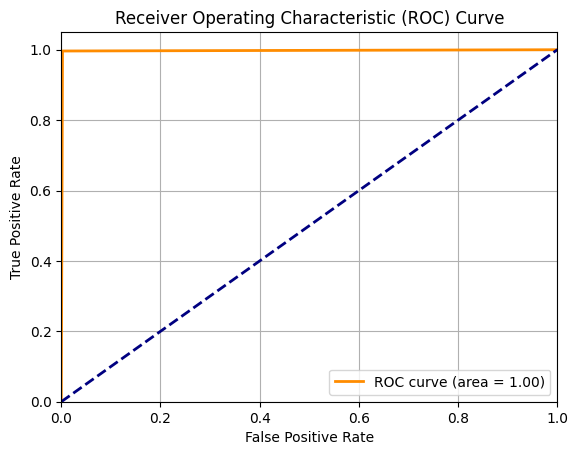

In [36]:
# prompt: dalla pipeline di cui sopra vorrei che facessi calcoli su indici di performance: accuracy, precision, sensitivity, specificity, che facessi una confusion matrix, una ROC e calcolassi Area Under the Curve AUC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

class PerformanceEvaluator(BaseEstimator, TransformerMixin):
    """
    A custom transformer to evaluate the performance of a classifier
    using various metrics (Accuracy, Precision, Sensitivity, Specificity),
    Confusion Matrix, ROC Curve, and AUC.

    Assumes the input is a tuple containing (trained_model, data_train, data_test),
    where data_test is a pandas DataFrame with features and the target variable
    (last column).
    """
    def __init__(self):
        self.accuracy = None
        self.precision = None
        self.sensitivity = None # Recall
        self.specificity = None
        self.confusion_matrix = None
        self.fpr = None
        self.tpr = None
        self.roc_auc = None

    def fit(self, X, y=None):
        """
        Evaluates the model performance on the test set.

        Args:
            X: A tuple containing (..., trained_model, data_train, data_test).
               data_test is a pandas DataFrame where the last column is the target.
               We only need the trained_model and data_test from the input tuple.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, tuple) or len(X) < 3:
            # We expect the input to have at least the model, train, and test data
            raise TypeError("Input X must be a tuple containing at least (..., trained_model, data_train, data_test).")

        # Extract the necessary elements from the input tuple
        # Assuming the last three elements are trained_model, data_train, data_test
        trained_model = X[-3]
        # data_train = X[-2] # Not needed for test set evaluation
        data_test = X[-1]

        if not isinstance(data_test, pd.DataFrame):
             raise TypeError("The last element in the input tuple must be a pandas DataFrame (data_test).")

        # Separate features (X_test) and true target (y_test) from data_test
        X_test = data_test.iloc[:, :-1]
        y_test = data_test.iloc[:, -1]

        print("\nEvaluating model performance on the test set...")

        # Make predictions on the test set
        y_pred = trained_model.predict(X_test)

        # Calculate performance metrics
        self.accuracy = accuracy_score(y_test, y_pred)
        self.precision = precision_score(y_test, y_pred)
        self.sensitivity = recall_score(y_test, y_pred) # Sensitivity is the same as Recall

        # Calculate Specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        self.specificity = tn / (tn + fp)

        print(f"Accuracy: {self.accuracy:.4f}")
        print(f"Precision: {self.precision:.4f}")
        print(f"Sensitivity (Recall): {self.sensitivity:.4f}")
        print(f"Specificity: {self.specificity:.4f}")

        # Calculate Confusion Matrix
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(self.confusion_matrix)

        # Calculate ROC Curve and AUC
        # Need predicted probabilities for ROC curve
        if hasattr(trained_model, "predict_proba"):
            y_prob = trained_model.predict_proba(X_test)[:, 1] # Probability of the positive class
            self.fpr, self.tpr, thresholds = roc_curve(y_test, y_prob)
            self.roc_auc = auc(self.fpr, self.tpr)
            print(f"\nROC AUC: {self.roc_auc:.4f}")
        else:
            print("\nModel does not have predict_proba method. Cannot compute ROC/AUC.")
            self.fpr, self.tpr, self.roc_auc = None, None, None


        return self

    def transform(self, X):
        """
        Returns the calculated performance metrics and results.

        Args:
            X: Input data (ignored, evaluation is done in fit).

        Returns:
            tuple: A tuple containing the evaluation results
                   (accuracy, precision, sensitivity, specificity,
                    confusion_matrix, fpr, tpr, roc_auc)
                    along with the original input tuple elements for
                    potential subsequent steps.
        """
        # Return the computed results and the original input tuple elements
        # This allows subsequent steps (if any) to access prior results
        return (self.accuracy, self.precision, self.sensitivity, self.specificity,
                self.confusion_matrix, self.fpr, self.tpr, self.roc_auc) + X


# Extend the existing pipeline to include the PerformanceEvaluator
pipeline_with_evaluation = Pipeline([
    ('download_and_extract', DataDownloaderExtractor(urls=urls, output_dir="downloaded_data")),
    ('load_csv', CSVLoader(x_filename='X_train.csv', y_filename='y_train.csv')),
    ('preprocess_and_split', DataPreprocessor(test_size=0.2, random_state=42)),
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)), # Use new_names_for_train_data which includes the target
    ('scale_data', DataScaler()), # This outputs (scaled_train, scaled_test)
    ('train_decision_tree', DecisionTreeTrainer()), # This outputs (model, scaled_train, scaled_test)
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42)), # This outputs (cv_scores, model, scaled_train, scaled_test)
    ('evaluate_performance', PerformanceEvaluator()) # Add the evaluator
])

# Run the pipeline
# The output will be a tuple (accuracy, precision, sensitivity, specificity,
# confusion_matrix, fpr, tpr, roc_auc, cv_scores, trained_model, scaled_data_train, scaled_data_test)
pipeline_output_with_evaluation = pipeline_with_evaluation.fit_transform(None)

# Access the evaluation results
accuracy, precision, sensitivity, specificity, cm, fpr, tpr, roc_auc = pipeline_output_with_evaluation[:8]
# You can also access other outputs from previous steps if needed:
# cv_scores, trained_dt_model, scaled_data_train, scaled_data_test = pipeline_output_with_evaluation[8:]


print("\nPerformance Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nConfusion Matrix:")
print(cm)
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("\nROC curve and AUC were not plotted as predict_proba was not available.")
